In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [93]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.5]
k = 2 * np.pi * 20 / 1500 * 100
L_pml = 0.3
sigma = 5

In [94]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [95]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [96]:
def get_dataset(Lx, Ly, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    x, y = torch.linspace(-Lx, Lx, 250), torch.linspace(-Ly, Ly, 250)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x0, y0 = x[-len(x):, :], y[-len(x):, :]
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x, y):
    import random as rd
    num = len(x)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id]

In [97]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()
    xy = torch.cat([x, y], dim=-1)

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res ** 2).mean()

def green(x, y, src, device=device, is_tensor='True'):
    if is_tensor:
        r = torch.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        r = r.detach().to('cpu').numpy()
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g_real, g_imag = torch.tensor(g_real, dtype=torch.float32), torch.tensor(g_imag, dtype=torch.float32)
        g = torch.cat([g_real, g_imag], dim=-1).to(device)
    else:
        r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g = np.concatenate([g_real, g_imag], axis=-1)
    return g

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L = Lx - L_pml
    x, y = torch.linspace(-L, L, n_coll), Ly * torch.ones(n_coll)
    x, y = torch.cat([x, x], dim=-1), torch.cat([y, -y], dim=-1)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src)
    return (res ** 2).mean()

In [98]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lamb = [1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
n_lamb_update = 50

In [126]:
n_epochs = int(3e2)
learning_rate = 2e-6
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [127]:
model = model.to(device)

In [128]:
x0, y0 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    for x, y in data_iter(10000, x0, y0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, k)
        loss_top = loss_bd(model, Lx, Ly, src)
        loss_lst = [loss_pde, loss_top]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde + lamb[1] * loss_top
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde: {loss_pde.item()}, Loss_bd: {loss_top.item()}')
    
        l_lst.append(loss)

/tmp/ipykernel_44668/3857430997.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_44668/3857430997.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)
/tmp/ipykernel_44668/609476976.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
/tmp/ipykernel_44668/609476976.py:57: UserWarning: To copy construct fr

Epoch 5, Loss: 0.00045483617577701807, Loss_pde: 0.00036453944630920887, Loss_bd: 2.3113881919556434e-09


  3%|▎         | 10/300 [00:11<05:34,  1.15s/it]

Epoch 10, Loss: 0.00019651914772111923, Loss_pde: 0.00017861621745396405, Loss_bd: 4.569553069266874e-10


  5%|▌         | 15/300 [00:17<06:00,  1.27s/it]

Epoch 15, Loss: 0.00019966496620327234, Loss_pde: 0.0001812098635127768, Loss_bd: 4.2263409438803023e-10


  7%|▋         | 20/300 [00:22<05:07,  1.10s/it]

Epoch 20, Loss: 0.00018894854292739183, Loss_pde: 0.0001691226934781298, Loss_bd: 4.5404024984208036e-10


  8%|▊         | 25/300 [00:28<05:12,  1.14s/it]

Epoch 25, Loss: 0.00021997337171342224, Loss_pde: 0.0001996853097807616, Loss_bd: 4.456498503557782e-10


 10%|█         | 30/300 [00:34<05:27,  1.21s/it]

Epoch 30, Loss: 0.00022107615950517356, Loss_pde: 0.0001984675182029605, Loss_bd: 5.033110594965251e-10


 12%|█▏        | 35/300 [00:39<04:49,  1.09s/it]

Epoch 35, Loss: 0.00023418515047524124, Loss_pde: 0.0002136699331458658, Loss_bd: 4.566889089119286e-10


 13%|█▎        | 40/300 [00:45<04:51,  1.12s/it]

Epoch 40, Loss: 0.0002215413114754483, Loss_pde: 0.00020075282372999936, Loss_bd: 4.687917276591236e-10


 15%|█▌        | 45/300 [00:51<04:59,  1.17s/it]

Epoch 45, Loss: 0.0002458012313582003, Loss_pde: 0.00019474944565445185, Loss_bd: 1.016880912807494e-09


 17%|█▋        | 50/300 [00:57<04:50,  1.16s/it]

Epoch 50, Loss: 0.0002347648551221937, Loss_pde: 0.0002015855279751122, Loss_bd: 6.828386744928139e-10


 18%|█▊        | 55/300 [01:02<04:28,  1.10s/it]

Epoch 55, Loss: 0.00025891922996379435, Loss_pde: 0.00021445812308229506, Loss_bd: 9.150480928532545e-10


 20%|██        | 60/300 [01:08<04:49,  1.21s/it]

Epoch 60, Loss: 0.00024240996572189033, Loss_pde: 0.0002194572880398482, Loss_bd: 4.939022524297343e-10


 22%|██▏       | 65/300 [01:15<05:11,  1.32s/it]

Epoch 65, Loss: 0.00023006316041573882, Loss_pde: 0.00020471855532377958, Loss_bd: 5.702612826397058e-10


 23%|██▎       | 70/300 [01:20<04:24,  1.15s/it]

Epoch 70, Loss: 0.00023304735077545047, Loss_pde: 0.00020073706400580704, Loss_bd: 7.270273827408857e-10


 25%|██▌       | 75/300 [01:26<04:27,  1.19s/it]

Epoch 75, Loss: 0.00026646675541996956, Loss_pde: 0.00021789506718050689, Loss_bd: 1.0159139085530455e-09


 27%|██▋       | 80/300 [01:33<04:52,  1.33s/it]

Epoch 80, Loss: 0.00021725744591094553, Loss_pde: 0.00019094721938017756, Loss_bd: 5.529758873024093e-10


 28%|██▊       | 85/300 [01:39<04:19,  1.21s/it]

Epoch 85, Loss: 0.00024267222033813596, Loss_pde: 0.00021533008839469403, Loss_bd: 5.746552123042648e-10


 30%|███       | 90/300 [01:45<04:24,  1.26s/it]

Epoch 90, Loss: 0.00024279601348098367, Loss_pde: 0.00021483120508491993, Loss_bd: 6.007201402979945e-10


 32%|███▏      | 95/300 [01:52<04:27,  1.31s/it]

Epoch 95, Loss: 0.0002581964654382318, Loss_pde: 0.0002297257597092539, Loss_bd: 6.511879369064388e-10


 33%|███▎      | 100/300 [01:58<04:13,  1.27s/it]

Epoch 100, Loss: 0.00021689548157155514, Loss_pde: 0.0001898766349768266, Loss_bd: 5.823853066466711e-10


 35%|███▌      | 105/300 [02:04<03:55,  1.21s/it]

Epoch 105, Loss: 0.0002854535705409944, Loss_pde: 0.0002308703842572868, Loss_bd: 1.176615804787673e-09


 37%|███▋      | 110/300 [02:11<04:07,  1.30s/it]

Epoch 110, Loss: 0.0002265309012727812, Loss_pde: 0.0002027472510235384, Loss_bd: 5.236588385137964e-10


 38%|███▊      | 115/300 [02:17<04:21,  1.41s/it]

Epoch 115, Loss: 0.00023865261755418032, Loss_pde: 0.00021503421885427088, Loss_bd: 5.315000661809677e-10


 40%|████      | 120/300 [02:23<03:40,  1.23s/it]

Epoch 120, Loss: 0.00025800452567636967, Loss_pde: 0.000219863883103244, Loss_bd: 8.58380255763791e-10


 42%|████▏     | 125/300 [02:30<03:41,  1.26s/it]

Epoch 125, Loss: 0.00024036709510255605, Loss_pde: 0.00021693992312066257, Loss_bd: 5.554720017286741e-10


 43%|████▎     | 130/300 [02:37<03:49,  1.35s/it]

Epoch 130, Loss: 0.0002434502966934815, Loss_pde: 0.00022331094078253955, Loss_bd: 4.97447583125421e-10


 45%|████▌     | 135/300 [02:43<03:20,  1.21s/it]

Epoch 135, Loss: 0.0002442678960505873, Loss_pde: 0.000218031884287484, Loss_bd: 6.480903591565834e-10


 47%|████▋     | 140/300 [02:49<03:18,  1.24s/it]

Epoch 140, Loss: 0.00024698107154108584, Loss_pde: 0.00022282300051301718, Loss_bd: 6.133847318956498e-10


 48%|████▊     | 145/300 [02:56<03:22,  1.31s/it]

Epoch 145, Loss: 0.00026334376889280975, Loss_pde: 0.00023648314527235925, Loss_bd: 6.989742118435061e-10


 50%|█████     | 150/300 [03:02<03:11,  1.28s/it]

Epoch 150, Loss: 0.00023554984363727272, Loss_pde: 0.0002131657092832029, Loss_bd: 5.446421647015143e-10


 52%|█████▏    | 155/300 [03:08<02:55,  1.21s/it]

Epoch 155, Loss: 0.00023792311549186707, Loss_pde: 0.0002060516271740198, Loss_bd: 7.755540099019242e-10


 53%|█████▎    | 160/300 [03:15<03:02,  1.30s/it]

Epoch 160, Loss: 0.00023987064196262509, Loss_pde: 0.00021570805984083563, Loss_bd: 5.687141313437394e-10


 55%|█████▌    | 165/300 [03:21<03:12,  1.43s/it]

Epoch 165, Loss: 0.00024830782786011696, Loss_pde: 0.00021647833636961877, Loss_bd: 7.126733092555071e-10


 57%|█████▋    | 170/300 [03:27<02:40,  1.24s/it]

Epoch 170, Loss: 0.00023295752180274576, Loss_pde: 0.00020764903456438333, Loss_bd: 5.666443980700819e-10


 58%|█████▊    | 175/300 [03:34<02:39,  1.28s/it]

Epoch 175, Loss: 0.00022542632359545678, Loss_pde: 0.00020172915537841618, Loss_bd: 5.537388325649317e-10


 60%|██████    | 180/300 [03:41<02:43,  1.36s/it]

Epoch 180, Loss: 0.000279614410828799, Loss_pde: 0.00021069831564091146, Loss_bd: 1.5322576540910404e-09


 62%|██████▏   | 185/300 [03:47<02:21,  1.23s/it]

Epoch 185, Loss: 0.000282141292700544, Loss_pde: 0.00022740430722478777, Loss_bd: 1.216968747996816e-09


 63%|██████▎   | 190/300 [03:53<02:20,  1.27s/it]

Epoch 190, Loss: 0.00025292971986345947, Loss_pde: 0.00021817728702444583, Loss_bd: 8.034825582647898e-10


 65%|██████▌   | 195/300 [04:00<02:20,  1.34s/it]

Epoch 195, Loss: 0.00023719464661553502, Loss_pde: 0.00021435992675833404, Loss_bd: 5.418089865649733e-10


 67%|██████▋   | 200/300 [04:07<02:10,  1.31s/it]

Epoch 200, Loss: 0.0002525428426451981, Loss_pde: 0.00021603879577014595, Loss_bd: 9.065567740940139e-10


 68%|██████▊   | 205/300 [04:13<01:57,  1.24s/it]

Epoch 205, Loss: 0.00023380157654173672, Loss_pde: 0.0002063548454316333, Loss_bd: 6.81592171591916e-10


 70%|███████   | 210/300 [04:20<01:59,  1.33s/it]

Epoch 210, Loss: 0.00023043905093800277, Loss_pde: 0.00020427278650458902, Loss_bd: 6.527654528021287e-10


 72%|███████▏  | 215/300 [04:26<02:03,  1.45s/it]

Epoch 215, Loss: 0.00024004705483093858, Loss_pde: 0.00021724907855968922, Loss_bd: 5.75629599541827e-10


 73%|███████▎  | 220/300 [04:33<01:41,  1.26s/it]

Epoch 220, Loss: 0.00025392588577233255, Loss_pde: 0.00021893724624533206, Loss_bd: 8.835176479315976e-10


 75%|███████▌  | 225/300 [04:39<01:37,  1.30s/it]

Epoch 225, Loss: 0.00025413406547158957, Loss_pde: 0.00021430182096082717, Loss_bd: 1.0203812239595322e-09


 77%|███████▋  | 230/300 [04:46<01:34,  1.36s/it]

Epoch 230, Loss: 0.00023316229635383934, Loss_pde: 0.00020575165399350226, Loss_bd: 7.275330338174513e-10


 78%|███████▊  | 235/300 [04:52<01:19,  1.22s/it]

Epoch 235, Loss: 0.0002252396079711616, Loss_pde: 0.00020140450214967132, Loss_bd: 6.326130730371915e-10


 80%|████████  | 240/300 [04:58<01:14,  1.25s/it]

Epoch 240, Loss: 0.00023157578834798187, Loss_pde: 0.00020729184325318784, Loss_bd: 6.450877054753335e-10


 82%|████████▏ | 245/300 [05:05<01:11,  1.30s/it]

Epoch 245, Loss: 0.00022831863316241652, Loss_pde: 0.00020557822426781058, Loss_bd: 6.260030271931782e-10


 83%|████████▎ | 250/300 [05:11<01:03,  1.27s/it]

Epoch 250, Loss: 0.00021322426619008183, Loss_pde: 0.0001948943390743807, Loss_bd: 4.94267293760231e-10


 85%|████████▌ | 255/300 [05:17<00:54,  1.21s/it]

Epoch 255, Loss: 0.0002854523481801152, Loss_pde: 0.00022214051568880677, Loss_bd: 1.7075688640844078e-09


 87%|████████▋ | 260/300 [05:24<00:52,  1.31s/it]

Epoch 260, Loss: 0.00024083796597551554, Loss_pde: 0.00021169967658352107, Loss_bd: 7.973837701236164e-10


 88%|████████▊ | 265/300 [05:31<00:50,  1.45s/it]

Epoch 265, Loss: 0.00028681682306341827, Loss_pde: 0.00024458213010802865, Loss_bd: 1.1480879580361147e-09


 90%|█████████ | 270/300 [05:37<00:37,  1.26s/it]

Epoch 270, Loss: 0.00027880555717274547, Loss_pde: 0.00024454144295305014, Loss_bd: 9.313823046142033e-10


 92%|█████████▏| 275/300 [05:44<00:32,  1.30s/it]

Epoch 275, Loss: 0.00020700680033769459, Loss_pde: 0.00019055797019973397, Loss_bd: 4.491625682501166e-10


 93%|█████████▎| 280/300 [05:50<00:27,  1.39s/it]

Epoch 280, Loss: 0.0002268425450893119, Loss_pde: 0.00021128749358467758, Loss_bd: 4.297513178652679e-10


 95%|█████████▌| 285/300 [05:57<00:18,  1.25s/it]

Epoch 285, Loss: 0.00022313582303468138, Loss_pde: 0.00019907436217181385, Loss_bd: 6.648682715493237e-10


 97%|█████████▋| 290/300 [06:03<00:12,  1.28s/it]

Epoch 290, Loss: 0.00032496763742528856, Loss_pde: 0.0002417933865217492, Loss_bd: 2.2392907528256956e-09


 98%|█████████▊| 295/300 [06:10<00:06,  1.34s/it]

Epoch 295, Loss: 0.00022422330221161246, Loss_pde: 0.00019887334201484919, Loss_bd: 7.209694508070186e-10


100%|██████████| 300/300 [06:17<00:00,  1.26s/it]

Epoch 300, Loss: 0.00022423150949180126, Loss_pde: 0.00020346741075627506, Loss_bd: 5.805332325969914e-10


In [129]:
def plot_field0(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1] + g[:, 0:1], p0[:, 1:2] + g[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('helmholtz.jpg')
    plt.tight_layout()

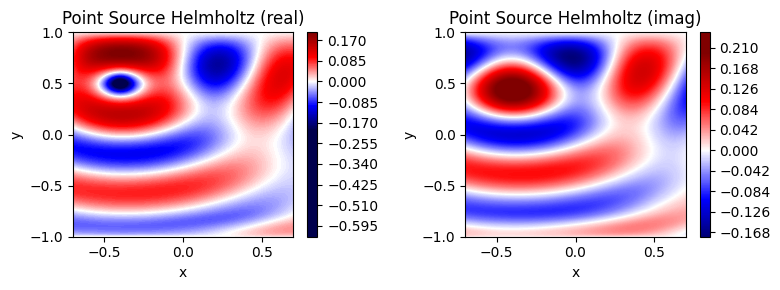

In [130]:
plot_field0(model.to('cpu'), 0.7, Ly)

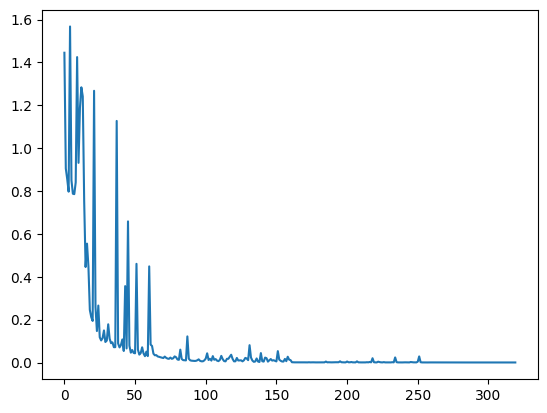

In [131]:
plot_loss(l_lst)

In [132]:
import joblib
joblib.dump(model.state_dict(), 'model_green.joblib')

['model_green.joblib']

In [133]:
def plot_field1(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1], p0[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('nogreen.jpg')
    plt.tight_layout()

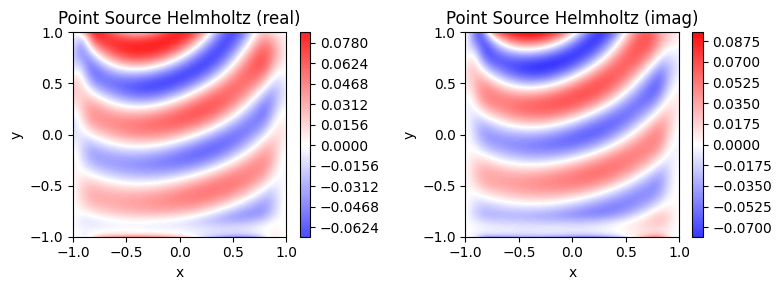

In [134]:
plot_field1(model.to('cpu'), 1, Ly)